In [1]:
%load_ext load_style
%load_style talk.css

# Compute correlation maps nino3-Sea Level Pressure

**Correlation analysis** are often used to examine climatological systems such as teleconnections. In this notebook, we will calculate the corelationship between ssta anomalies in nino3 area and mean sea level pressure(MSLP). 

**SLP** Data Source:

* Brief Description:
> NCEP/NCAR Reanalysis 1

* Temporal Coverage:
> 4-times daily, daily and monthly values for 1948/01/01 to present

* Spatial Coverage:
> 2.5 degree latitude x 2.5 degree longitude global grid (144x73) <br>
> 90N - 90S, 0E - 357.5E

See more from https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html

## 1. Load basic libs

In [2]:
% matplotlib inline

import numpy as np
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset as netcdf # netcdf4-python module

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 9

## 2. Read nino3 SSTA series

Please keep in mind that the nino3 SSTA series lies between 1970 and 1999 <br>
Recall ex2

In [3]:
npzfile = np.load('data/ssta.nino3.30y.npz')
npzfile.files

['ssta_series']

In [4]:
ssta_series = npzfile['ssta_series']
ssta_series.shape

(360L, 1L)

## 3. Read monthly mean sea levep pressure

In [5]:
ncset= netcdf(r'data/slp.mon.mean.1970.1999.nc')

lons = ncset['lon'][:]  
lats = ncset['lat'][:]            
slp = ncset['slp'][:,:,:]   

nt,nlat,nlon = slp.shape
ngrd = nlat*nlon
nyr  = nt/12

## 4. Remove SLP seasonal cycle

In [6]:
slp_grd  = slp.reshape((12,nyr, ngrd), order='F').transpose((1,0,2))
slp_clim = np.mean(slp_grd, axis=0)
slp_anom = (slp_grd - slp_clim).transpose((1,0,2)).reshape((nt, ngrd), order='F')

slp_anom[:,1].shape

(360L,)

## 5. Calculate correlationship between ssta and slp

In [7]:
corr = np.zeros((1, ngrd))
pval = np.zeros((1, ngrd))

In [8]:
for igrd in np.arange(ngrd):
    crr,pvalue = pearsonr(ssta_series[:,0], slp_anom[:,igrd])
    corr[0,igrd] = crr
    pval[0,igrd] = pvalue   

In [9]:
corr = corr.reshape((nlat,nlon), order='F')
pval = pval.reshape((nlat,nlon), order='F')

## 6. Visualize
Correlation and correlation at 5% significant level

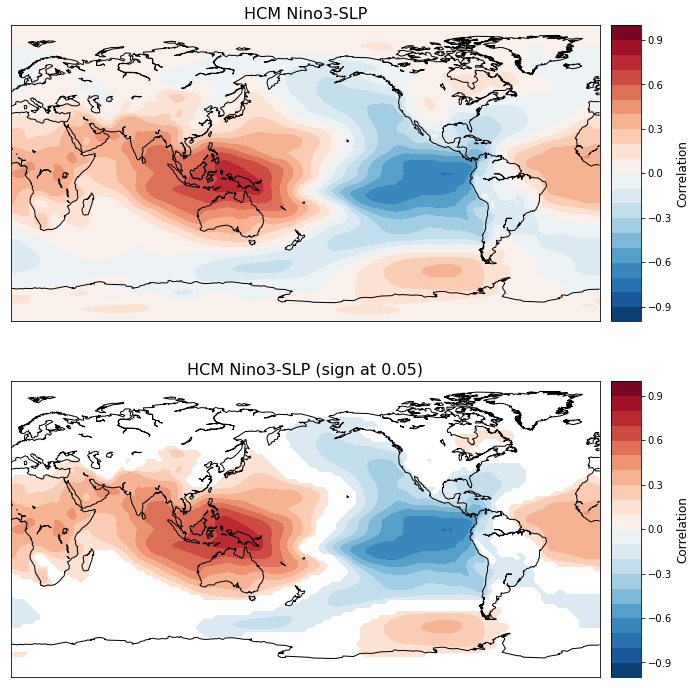

In [10]:
# Correlation
m = Basemap(projection='cyl', llcrnrlon=min(lons), llcrnrlat=min(lats),
        urcrnrlon=max(lons), urcrnrlat=max(lats))

x, y = m(*np.meshgrid(lons, lats))
clevs = np.linspace(-1.0, 1.0, 21)

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(211)
cs = m.contourf(x, y, corr.squeeze(), clevs, cmap=plt.cm.RdBu_r)
m.drawcoastlines()

cb = m.colorbar(cs)
cb.set_label('Correlation', fontsize=12)
ax.set_title('HCM Nino3-SLP', fontsize=16)

#correlation at 5% significant level
ax = fig.add_subplot(212)
corr_sig = np.ma.masked_array(corr, mask=(pval>=0.05))
cs = m.contourf(x, y, corr_sig.squeeze(), clevs, cmap=plt.cm.RdBu_r)
m.drawcoastlines()

cb = m.colorbar(cs)
cb.set_label('Correlation', fontsize=12)
ax.set_title('HCM Nino3-SLP (sign at 0.05)', fontsize=16)

## References

http://unidata.github.io/netcdf4-python/

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Kalnay et al.,The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470, 1996.